# Chain

### Goals
Now, let's build up to a simple chain that combines 4 concepts:

Using chat messages as our graph state
Using chat models in graph nodes
Binding tools to our chat model
Executing tool calls in graph nodes
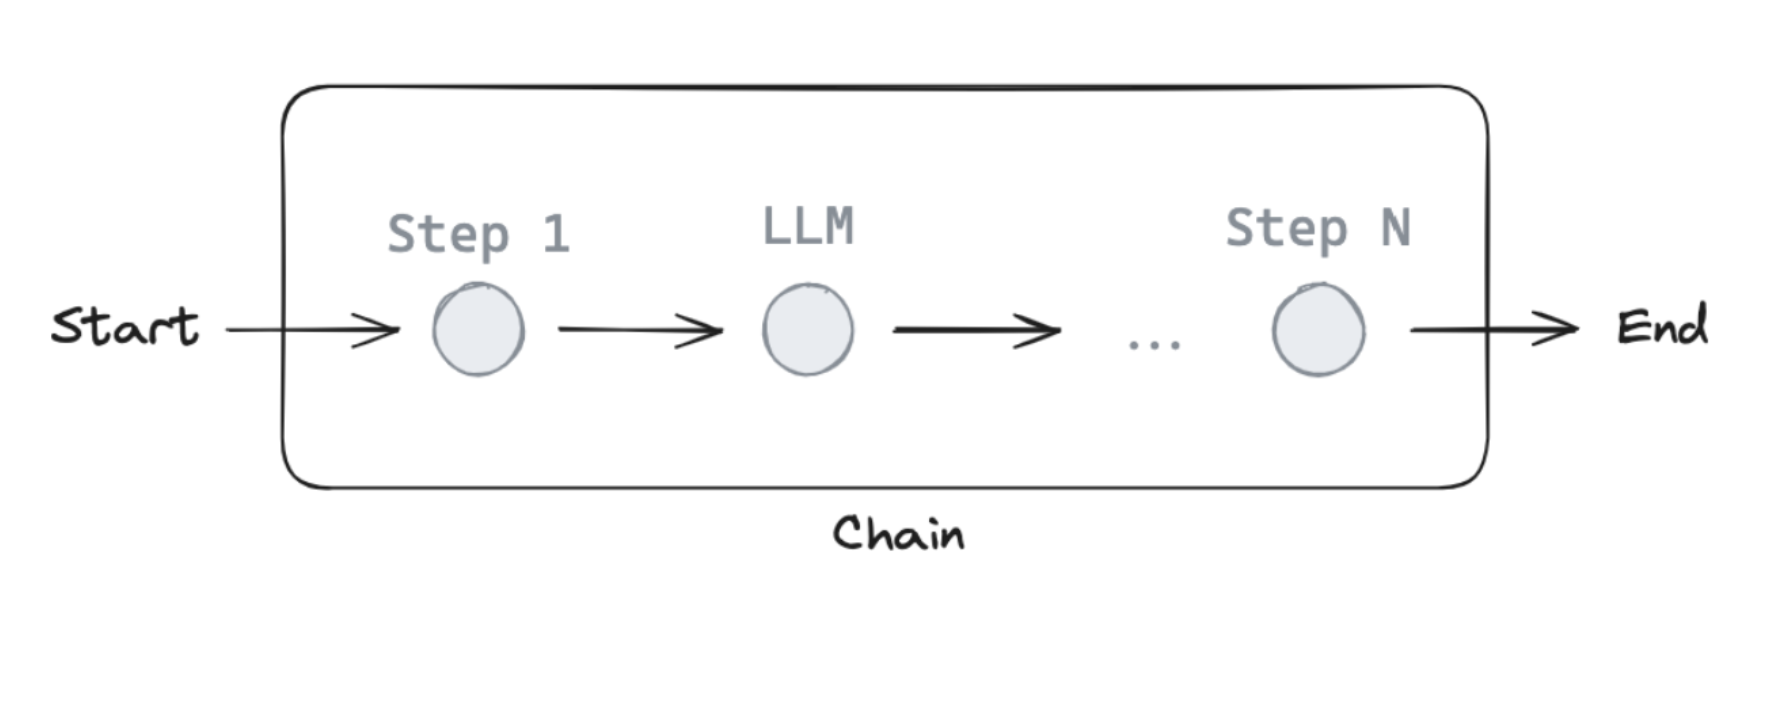

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

### Messages
Chat models can use messages, which capture different roles within a conversation.

LangChain supports various message types, including HumanMessage, AIMessage, SystemMessage, and ToolMessage.

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Let's create a list of messages.

Each message can be supplied with a few things:

content - content of the message
name - optionally, a message author
response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching space waste?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Viraja"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to know which country is responsible for most of the space junk.", name="Viraja"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching space waste?
================================ Human Message =================================
Name: Viraja

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Viraja

I want to know which country is responsible for most of the space junk.


### Chat Models
Chat models can use a sequence of message as input and support message types, as discussed above.

There are many to choose from! Let's work with OpenAI.

Let's check that your OPENAI_API_KEY is set and, if not, you will be asked to enter it.

In [5]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We can load a chat model and invoke it with out list of messages.

We can see that the result is an AIMessage with specific response_metadata.

In [6]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [7]:
result

AIMessage(content="As of the latest data, the countries that have historically contributed the most to space debris are those with the largest space programs, specifically:\n\n1. **Russia/Former Soviet Union**: As one of the pioneers in space exploration, the Soviet Union (and now Russia) has launched numerous satellites and other space missions, leaving behind a significant amount of debris over the decades.\n\n2. **United States**: Similar to Russia, the U.S. has an extensive history in space exploration, resulting in a substantial amount of space debris from various rocket launches, satellite deployments, and decommissioned spacecraft.\n\n3. **China**: In recent years, China's space program has rapidly expanded, leading to an increase in its share of space debris. Notably, a 2007 anti-satellite missile test created a significant amount of space junk.\n\nThese three countries are responsible for the majority of the larger pieces of space debris, although many other countries and priv

In [8]:
result.response_metadata

{'token_usage': {'completion_tokens': 259,
  'prompt_tokens': 68,
  'total_tokens': 327,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-2024-08-06',
 'system_fingerprint': 'fp_eb3c3cb84d',
 'id': 'chatcmpl-CRQZVTOQz0dHB5qjHjXebFNk7pBsY',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

### Tools
Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, it will return an output that adheres to the tool's schema.

Many LLM providers support tool calling and tool calling interface in LangChain is simple.

You can simply pass any Python function into ChatModel.bind_tools(function).

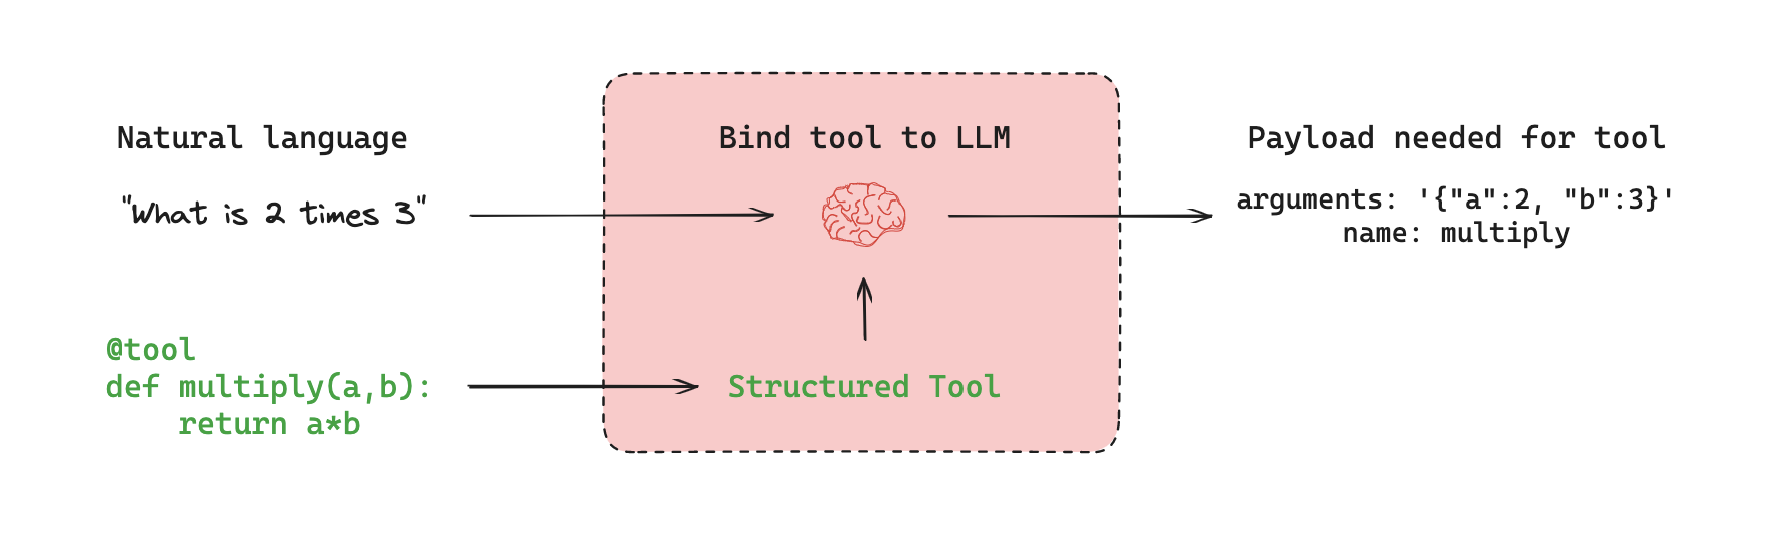

Let's showcase a simple example of tool calling!

The multiply function is our tool.

In [9]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

If we pass an input - e.g., "What is 2 multiplied by 3" - we see a tool call returned.

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}

In [13]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Viraja")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bKvOwkHCK3nhdMmuUiRoW0lz', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 63, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CRQbQTN2TblgxSohwJtww9Cubpz68', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2e3b3b50-d384-4e5f-a153-8a5f6644545f-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_bKvOwkHCK3nhdMmuUiRoW0lz', 'type': 'tool_call'}], usage_metadata={'input_tokens': 63, 'output_tokens': 17, 'total_tokens': 80, 'input_token_details': {'audio': 0, 'cache_rea

In [14]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_bKvOwkHCK3nhdMmuUiRoW0lz',
  'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
  'type': 'function'}]

### Using messages as state
With these foundations in place, we can now use messages in our graph state.

Let's define our state, MessagesState, as a TypedDict with a single key: messages.

messages is simply a list of messages, as we defined above (e.g., HumanMessage, etc).

In [15]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

### Reducers
Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will override the prior messages value.

As our graph runs, we want to append messages to our messages state key.

We can use reducer functions to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our messages key with the add_messages reducer function as metadata.

In [16]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built MessagesState!

MessagesState is defined:

With a pre-build single messages key
This is a list of AnyMessage objects
It uses the add_messages reducer
We'll usually use MessagesState because it is less verbose than defining a custom TypedDict, as shown above.

In [17]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

To go a bit deeper, we can see how the add_messages reducer works in isolation.

In [19]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Viraja")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='7918c037-6e26-4190-944f-4c558bbdc610'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Viraja', id='11c1ba26-73db-4a8a-845a-485d491028c0'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='8b24e02b-16b7-4378-b99a-3ec7921a82cf')]

### Our graph
Now, lets use MessagesState with a graph.

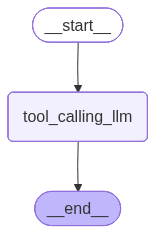

In [21]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


In [23]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_kzIpVoVuIKm3eZ2BlWq5MkM3)
 Call ID: call_kzIpVoVuIKm3eZ2BlWq5MkM3
  Args:
    a: 2
    b: 3
